[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/estebanbecerra/MLEX-Practicas/blob/main/AirQuality.ipynb)

**Asignatura**: MACHINE LEARNING EXPLICABLE \\
**Curso**: 2024/2025

**Alumnos**:<br>
- Esteban Becerra Fernández
- Salvador de Haro Orenes (salvadorde.haroo@um.es)
- Jose María Belmonte Martínez (josemaria.belmontem@um.es)

**Máster de Inteligencia Artificial**

**Facultad de Informática**

![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242)

**Universidad de Murcia**

![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png)

# Configuración del entorno

## Instalación de dependencias

In [34]:
!pip install lime

## Importación de librerías

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from lime.lime_tabular import LimeTabularExplainer

## Semilla para repdroducción de resultados

In [36]:
SEED = 1234

# Carga de datos y preprocesamiento

## **Air Quality Dataset**

El conjunto de datos contiene 9357 instancias de respuestas promediadas por hora de una matriz de 5 sensores químicos de óxidos metálicos integrados en un Dispositivo Multisensor de Calidad del Aire. El dispositivo se ubicó en el campo en una zona significativamente contaminada, a nivel de la carretera, dentro de una ciudad italiana. Los datos se registraron desde marzo de 2004 hasta febrero de 2005 (un año), representando las grabaciones más largas disponibles de manera libre sobre las respuestas de dispositivos sensores químicos de calidad del aire desplegados en campo.

Las concentraciones promediadas por hora de referencia para CO, hidrocarburos no metánicos, benceno, óxidos de nitrógeno totales (NOx) y dióxido de nitrógeno (NO2) fueron proporcionadas por un analizador certificado de referencia ubicado en el mismo sitio. Los valores faltantes están etiquetados con el valor -200.

In [37]:
import pandas as pd

# Cargar CSV
df = pd.read_csv("AirQuality.csv", sep=";")

# Mostrar las primeras filas
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [38]:
#mostrar datos estadísticos de features numéricas
df.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,NaN,NaN
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,NaN,NaN
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,NaN,NaN
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,NaN,NaN
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,NaN,NaN
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,NaN,NaN


### Descripción de los Atributos del Dataset

| #  | Atributo | Descripción |
|----|---------|------------|
| 0  | Date (DD/MM/YYYY) | Fecha en formato día/mes/año |
| 1  | Time (HH.MM.SS) | Hora en formato horas.minutos.segundos |
| 2  | True hourly averaged concentration CO in mg/m³ (reference analyzer) | Concentración real promediada por hora de CO en mg/m³ (analizador de referencia) |
| 3  | PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted) | Respuesta promediada por hora del sensor PT08.S1 (óxido de estaño) (dirigido nominalmente a CO) |
| 4  | True hourly averaged overall Non Metanic HydroCarbons concentration in µg/m³ (reference analyzer) | Concentración real promediada por hora de hidrocarburos no metánicos en µg/m³ (analizador de referencia) |
| 5  | True hourly averaged Benzene concentration in µg/m³ (reference analyzer) | Concentración real promediada por hora de Benceno en µg/m³ (analizador de referencia) |
| 6  | PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) | Respuesta promediada por hora del sensor PT08.S2 (titania) (dirigido nominalmente a NMHC) |
| 7  | True hourly averaged NOx concentration in ppb (reference analyzer) | Concentración real promediada por hora de NOx en ppb (analizador de referencia) |
| 8  | PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) | Respuesta promediada por hora del sensor PT08.S3 (óxido de tungsteno) (dirigido nominalmente a NOx) |
| 9  | True hourly averaged NO2 concentration in µg/m³ (reference analyzer) | Concentración real promediada por hora de NO2 en µg/m³ (analizador de referencia) |
| 10 | PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted) | Respuesta promediada por hora del sensor PT08.S4 (óxido de tungsteno) (dirigido nominalmente a NO2) |
| 11 | PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) | Respuesta promediada por hora del sensor PT08.S5 (óxido de indio) (dirigido nominalmente a O3) |
| 12 | Temperature in °C | Temperatura en °C |
| 13 | Relative Humidity (%) | Humedad relativa (%) |
| 14 | AH Absolute Humidity | Humedad absoluta |


In [39]:
df.shape[1]

17

Como podemos observar en la celda superior tenemos 17 columnas, pero al parecer las dos últimas son sobrantes pues en la información del dataset solo se indican 15 atributos y además los valores que presentan dichas columnas son nulos. Lo que vamos a hacer a continuación es ver los tipos de datos que tenemos.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


## **Preprocesamiento**

Vemos que hay tanto variables categóricas como variables numéricas. También vemos que se nos informa de que hay 9471 instancias, pero de las cuales $9471 - 9357 = 114$ tienen todas las features a `null`. A continuación vamos a eliminar las dos últimas columnas por ser redundantes.

In [41]:
df = df.iloc[:, :-2]

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


In [43]:
# Verificar si hay valores nulos en cada columna
valores_nulos = df.isna().any()

# Filtrar y mostrar solo las columnas que tienen al menos un valor nulo
print("Columnas con valores nulos:")
print(valores_nulos[valores_nulos])  # Solo muestra las columnas donde el valor es True

Columnas con valores nulos:
Date             True
Time             True
CO(GT)           True
PT08.S1(CO)      True
NMHC(GT)         True
C6H6(GT)         True
PT08.S2(NMHC)    True
NOx(GT)          True
PT08.S3(NOx)     True
NO2(GT)          True
PT08.S4(NO2)     True
PT08.S5(O3)      True
T                True
RH               True
AH               True
dtype: bool


Arriba podemos ver como todas las columnas presentan valores nulos. De momento no vamos a aplicar ningún tratamiento, pero lo que si haremos será sustituir el -200 que indica un nulo por NaN. Otra cosa que debemos hacer para proceder con el feature engineering es sustituir las variables categóricas por numéricas.

In [44]:
df.replace(to_replace=-200,value=np.nan,inplace=True)

In [45]:
# Lista de columnas categóricas
columnas_a_convertir = ["CO(GT)", "C6H6(GT)", "T", "RH", "AH"]

# Reemplazar comas por puntos en las columnas problemáticas
df[columnas_a_convertir] = df[columnas_a_convertir].replace(',', '.', regex=True)

# Convertir las columnas a float, ignorando errores (convierte valores no numéricos en NaN)
df[columnas_a_convertir] = df[columnas_a_convertir].apply(pd.to_numeric, errors="coerce")

A continuación vamos a formatear Date y Time al tipo DateTime por sencillez.

In [46]:
# Convertir "Date" y "Time" en un solo datetime
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H.%M.%S")

# Eliminar las columnas originales
df = df.drop(columns=["Date", "Time"])

# Mostrar el DataFrame con la nueva columna
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


In [47]:
print(df.isnull().sum())

CO(GT)            114
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          114
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 114
RH                114
AH                114
datetime          114
dtype: int64


Volviendo al tema de los valores nulos, observamos que la columna NMHC(GT) tiene muchísimos valores nulos en prácticamente todas las instancias, por lo que vamos a eliminarla.

In [48]:
df = df.drop(columns=["NMHC(GT)"])

En cuanto al resto de atributos, vamos a proceder rellenando los valores nulos con la mediana por sencillez. Al tratarse de series temporales, lo más ideal sería hacer una interpolación, pero nuestro objetivo no es obtener un modelo excelente.

In [49]:
df = df.fillna(df.median())

In [50]:
print(df.isnull().sum())

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
datetime         0
dtype: int64


Podemos observar que ya no hay valores nulos.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9471 non-null   float64       
 1   PT08.S1(CO)    9471 non-null   float64       
 2   C6H6(GT)       9471 non-null   float64       
 3   PT08.S2(NMHC)  9471 non-null   float64       
 4   NOx(GT)        9471 non-null   float64       
 5   PT08.S3(NOx)   9471 non-null   float64       
 6   NO2(GT)        9471 non-null   float64       
 7   PT08.S4(NO2)   9471 non-null   float64       
 8   PT08.S5(O3)    9471 non-null   float64       
 9   T              9471 non-null   float64       
 10  RH             9471 non-null   float64       
 11  AH             9471 non-null   float64       
 12  datetime       9471 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(12)
memory usage: 962.0 KB


Además, ya tenemos todos nuestros atributos en formato numérico.

In [52]:
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


Llegados a este punto el dataset ya está listo para su uso, pero antes que nada debemos estudiar sus atributos, es decir, estudiar escala de los datos y correlación entre las variables. Lo primero va a ser ver la cantidad de outliers que tenemos en el dataset.

In [53]:
# Calcular el rango intercuartil (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Definir umbrales para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Contar cuántos outliers hay por columna
outliers = ((df < limite_inferior) | (df > limite_superior)).sum()
print(outliers)

CO(GT)           1898
PT08.S1(CO)       158
C6H6(GT)          624
PT08.S2(NMHC)      96
NOx(GT)           803
PT08.S3(NOx)      290
NO2(GT)           399
PT08.S4(NO2)      142
PT08.S5(O3)       147
T                 368
RH                366
AH                367
datetime            0
dtype: int64


El fragmento de código definido arriba sirve para observar los outliers que tenemos en cada atributo, y como podemos observar, hay bastantes, es así que tendremos que hacer algo al respecto.

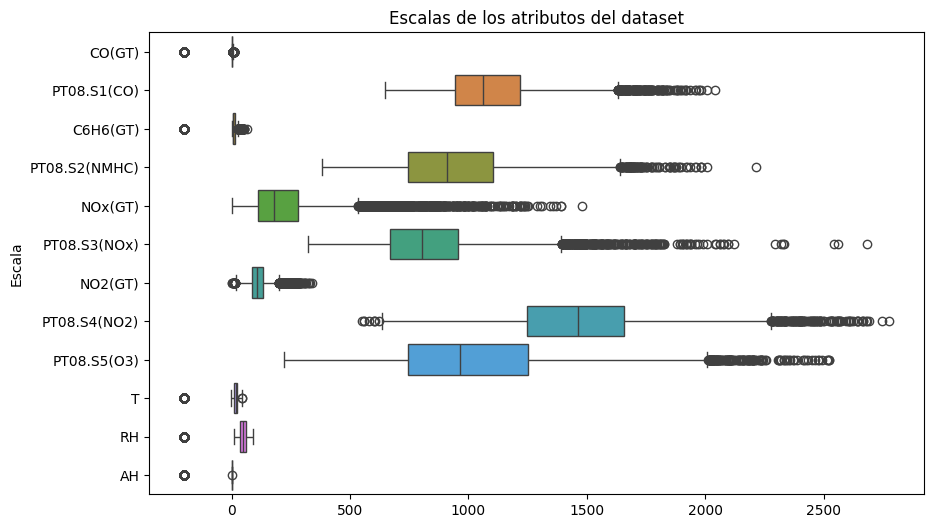

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, orient = 'h')
plt.title('Escalas de los atributos del dataset')
plt.ylabel('Escala')
plt.show()

En la imagen superior podemos ver la escala de los datos, y, aparte de tener una gran cantidad de outliers como decíamos previamente, la escala es muy dispar, por lo que tenemos que aplicar normalización. En nuestro caso vamos a eliminar los outliers extremos usando el método del rango intercuartílico (IQR), y tras eso aplicaremos normalización, en nuestro caso hemos elegido RobustScaler, ya que usa la mediana y el rango intercuartil en lugar de la media y desviación estándar, lo que lo hace más robusto.

<ipython-input-55-ad3bfe70c283>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])


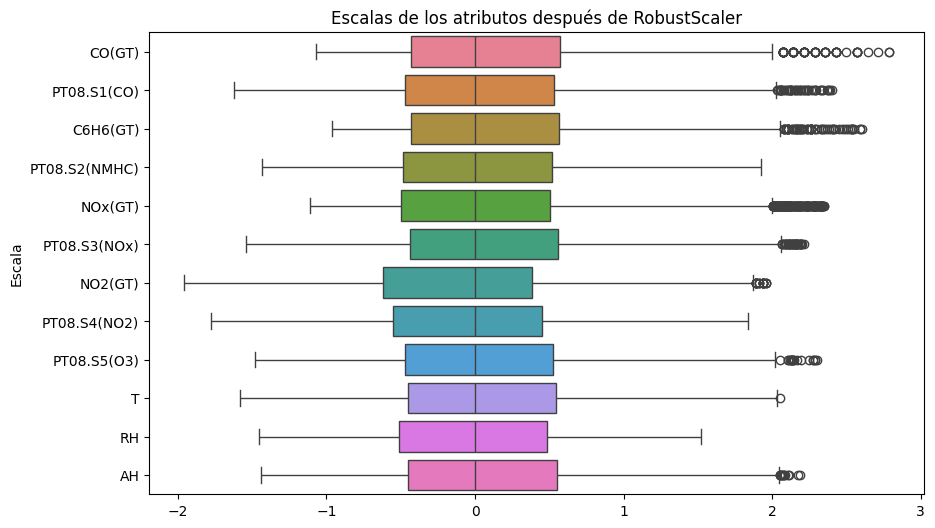

In [55]:
from sklearn.preprocessing import RobustScaler

# Seleccionar solo las columnas numéricas
columnas_numericas = df.select_dtypes(include=["float64"]).columns

Q1 = df[columnas_numericas].quantile(0.25)
Q3 = df[columnas_numericas].quantile(0.75)
IQR = Q3 - Q1

# Filtrar valores dentro de 1.5*IQR
df = df[~((df[columnas_numericas] < (Q1 - 1.5 * IQR)) | (df[columnas_numericas] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Aplicar RobustScaler
scaler = RobustScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

# Verificar con boxplot después de escalar

plt.figure(figsize=(10,6))
sns.boxplot(data=df[columnas_numericas], orient='h')
plt.title('Escalas de los atributos después de RobustScaler')
plt.ylabel('Escala')
plt.show()


El siguiente paso es estudiar correlación entre las variables, para ello vamos a hacer un plot de una matriz de correlación. Vamos a seguir el siguiente criterio:

- r > 0.7 o r < -0.7 → Fuerte correlación
- 0.5 < |r| < 0.7 → Correlación moderada
- |r| < 0.5 → Débil o sin correlación

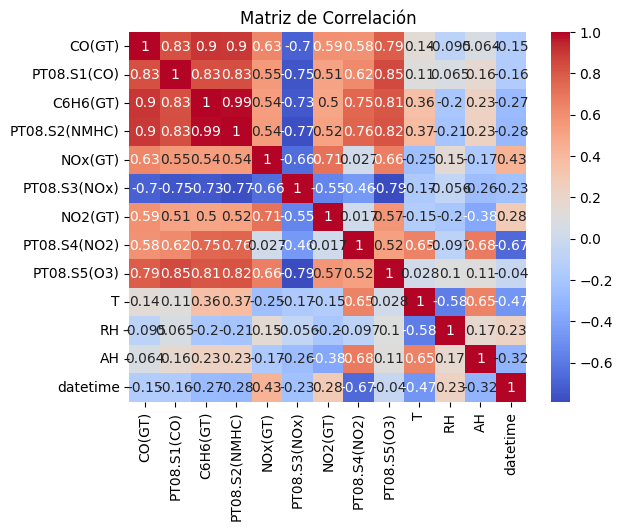

In [56]:
sns.heatmap(df.corr(),annot=True,cmap = 'coolwarm')
plt.title('Matriz de Correlación')
plt.show()

En la imagen, se observa lo siguiente:

- C6H6(GT) y PT08.S2(NMHC) tienen una correlación de ~0.99
- PT08.S5(O3) y PT08.S1(CO) tienen alta correlación (~0.85 - 0.9)
- CO(GT) y C6H6(GT) están altamente correlacionadas (~0.9)

Evidentemente hay más variables altamente correlacionadas, pero esas son las más notables.

Lo que vamos a hacer es eliminar C6H6 por estar altamente correlacionada con CO y PT08.S2, para evitar problemas de multicolinealidad.

In [57]:
# Eliminar variables redundantes
df = df.drop(columns=["C6H6(GT)"])

print(df.columns)

Index(['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
       'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'datetime'],
      dtype='object')


Por último lo que vamos a hacer es introducir nuevas características que puedan resultar interesantes. Los datos tienen un componente temporal importante, ya que todos los datos están modelados según un instante de tiempo que ahora tenemos definido con DateTime. Para poder aprovechar ese carácter secuencial de los datos lo que vamos a hacer es intruducir las siguientes variables: Hora del día, día de la semana, mes, día del año y semana del año. De esta manera eliminamos DateTime (ya que al no ser numerica no podemos usarla para entrenamiento) pero mantenemos información relativa al tiempo.

In [58]:
# Extraer características temporales del datetime
df["hour"] = df["datetime"].dt.hour  # Hora del día (0-23)
df["day_of_week"] = df["datetime"].dt.dayofweek  # Día de la semana (0=Monday, ..., 6=Sunday)
df["month"] = df["datetime"].dt.month  # Mes (1-12)
df["day_of_year"] = df["datetime"].dt.dayofyear  # Día del año (1-365)
df["week_of_year"] = df["datetime"].dt.isocalendar().week  # Semana del año

# Ahora podemos eliminar la columna datetime
df = df.drop(columns=["datetime"])

In [59]:
df.head()

,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,day_of_week,month,day_of_year,week_of_year
0,0.714286,1.289916,0.496815,-0.079470,0.921002,0.085106,0.551876,0.721348,-0.337349,0.029963,-0.398218,18,2,3,70,11
1,0.285714,1.004202,0.207006,-0.496689,1.375723,-0.361702,0.258278,0.056180,-0.361446,-0.014981,-0.456951,19,2,3,70,11
2,0.428571,1.466387,0.156051,-0.311258,1.244701,0.106383,0.249448,0.285393,-0.473896,0.220974,-0.412037,20,2,3,70,11
3,0.428571,1.357143,0.184713,-0.039735,1.059730,0.276596,0.313466,0.575281,-0.546185,0.445693,-0.345668,21,2,3,70,11
4,0.000000,0.920168,-0.171975,-0.311258,1.495183,0.148936,0.105960,0.366292,-0.530120,0.430712,-0.341849,22,2,3,70,11


Llegados a este punto ya tenemos el dataset listo para empezar a experimentar con los entrenamientos de los modelos.

# **Entrenamiento de modelos de ML**

Para proceder con el entrenamiento hay que elegir una variable target, en nuestro caso hemos optado por el sensor PT08.S1(CO), ya que puede ser un buen indicador de la calidad del aire.

In [60]:
# Separar variables predictoras (X) y variable objetivo (Y)
y = df["PT08.S1(CO)"]
X = df.drop(columns=["PT08.S1(CO)"])  # Eliminamos la variable objetivo y datetime

# División del dataset en 80% entrenamiento y 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (5007, 15), Test Shape: (1252, 15)


## Random Forest Regressor

Entrenamos un modelo Random Forest para regresión mediante el ajuste de hiperparámetros con validación cruzada de 3 pliegues. Como estamos en regresión, la métrica que nos indicará el mejor modelo es el coeficiente de determinación $R^2$, que indica qué tan bien un modelo de regresión explica la variabilidad de la variable objetivo en función de las variables independientes (features).

In [62]:
# Definir la cuadrícula de hiperparámetros
param_grid = {
    "n_estimators": [50, 75, 100],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Crear el modelo base
rf_model = RandomForestRegressor(random_state=SEED)

# Configurar Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring="r2", n_jobs=-1, verbose=2)

# Ajustar el modelo con Grid Search
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_best = best_rf.predict(X_test)

# Evaluar métricas
print("\nRandom Forest Optimizado")
print(f"R² Score: {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_best):.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: 

In [ ]:
aux = pd.DataFrame()

aux['Y_test'] = y_test
aux['Predictions RandomForest_01'] = y_pred_best

plt.figure(figsize=(15,5))
sns.lineplot(data=aux.iloc[:200,:])
plt.show()

Podemos observar que el modelo RF se adapta bastante bien en sus predicciones a la variable objetivo, aunque sí que es cierto que le cuesta un poco predecir los picos más abruptos. De todos modos el R2 score es de 0.95 y el MAE de 0.11, lo que indica un rendimiento excelente.

# Métodos de ML explicativos

## LIME

Comenzamos utilizando el método LIME (Local Interpretable Model-Agnostic Explanations) para dar una exlicación local (es decir, de una única instancia) del funcionamiento de los modelos de caja negra que hemos entrenado en el apartado anterior.

### Crear el explicador LIME

In [ ]:
# LIME explainer para datos tabulares
explainer = LimeTabularExplainer(X.values, #para generar el vecindario artificial
                                 feature_names=X.columns,
                                 class_names=["PT08.S1(CO)"], # la variable objetivo (target)
                                 mode = 'regression', #estamos en modo regresión
                                 random_state=SEED)

## Explicación local de una instancia

Seleccionamos una instancia aleatoria del dataset y daremos una epxlicación de la salida obtenida por los modelos de caja negra para esa instancia a través de un modelo sub-rogado, que será en este caso un modelo lineal Ridge (por defecto en LIME).

Definimos una función genérica, `local_explanation_lime`, para generar la explicación local. Esta función que recibe como argumentos:
- Indice en el dataset de la instancia a explicar.
- Modelo de caja negra.

In [ ]:
def local_explanation_lime(index_instance:int, blackBoxModel):
    assert index_instance >= X.shape[0] or index_instance < 0, "Index out of bounds"

    exp = explainer.explain_instance(X.values[index_instance], #la instancia a explicar
                                 blackBoxModel.predict,
                                 num_features=X.shape[1] #numero de features de las cuales va a dar explicación
                                 )

    exp.show_in_notebook(show_all=False)